In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [7]:
dataset_path = "/content/drive/MyDrive/Training"
target_size = (224, 224)

In [8]:
images = []
labels = []


In [9]:
for tumor_type in os.listdir(dataset_path):
    tumor_type_path = os.path.join(dataset_path, tumor_type)

    for image_file in os.listdir(tumor_type_path):
        image_path = os.path.join(tumor_type_path, image_file)

        img = cv2.imread(image_path)
        img = cv2.resize(img, target_size)

        images.append(img)
        labels.append(tumor_type)

        # Data Augmentation
        datagen = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            height_shift_range=0.2,
            width_shift_range=0.2,
            shear_range=0.2,
            fill_mode='nearest'
        )

        augmented_images = [datagen.random_transform(img) for _ in range(1)]
        images.extend(augmented_images)
        labels.extend([tumor_type] * len(augmented_images))


In [10]:
X = np.array(images)
y = np.array(labels)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained MobileNetV2 model (including the top layers for classification)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model using the MobileNetV2 base and adding your custom top layers for classification
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming there are 6 classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model with validation data
history = model.fit(X_train, y_train_encoded, epochs=32, batch_size=16, validation_data=(X_val, y_val_encoded))





9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 2422468 (9.24 MB)
Trainable params: 164484 (642.52 KB)
Non-trainable params: 2257984 (8.61 MB)
________________

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import matplotlib.pyplot as plt




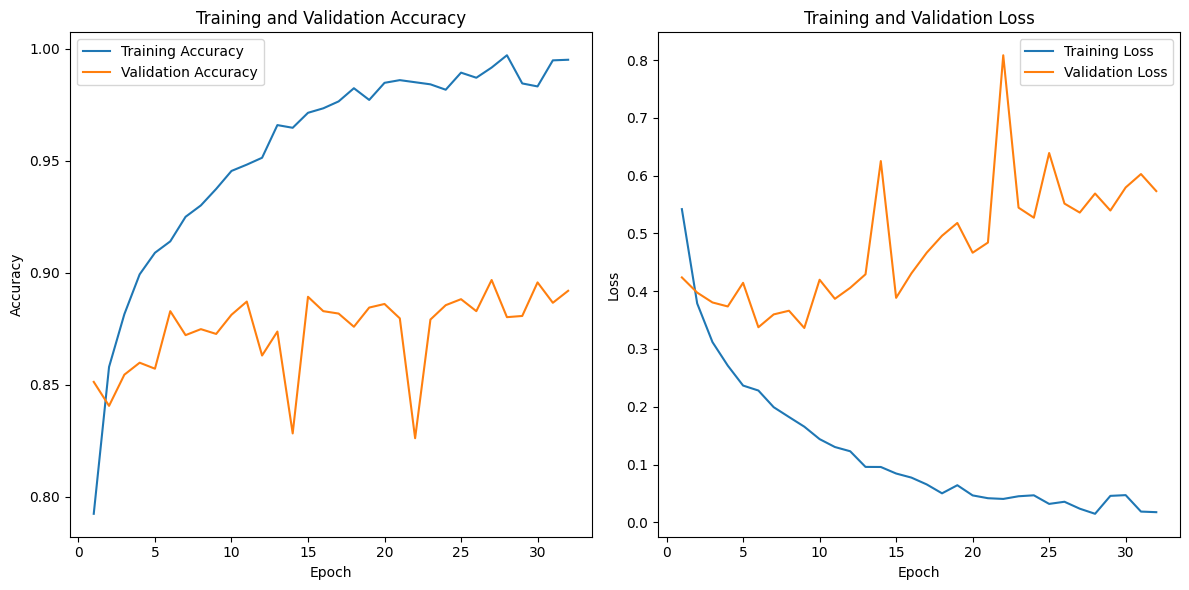

In [16]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [18]:
# Extract features using the CNN model
X_train_features = model.predict(X_train)
X_val_features = model.predict(X_val)

59/59 [==============================] - 2s 33ms/step


In [19]:
# Reshape data for Random Forest
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flatten = X_val_features.reshape(X_val_features.shape[0], -1)

In [20]:
# Initialize Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Train Random Forest classifier
random_forest_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on validation set
random_forest_predictions = random_forest_classifier.predict(X_val_flatten)

# Evaluate performance
random_forest_accuracy = metrics.accuracy_score(y_val_encoded, random_forest_predictions)
random_forest_precision = metrics.precision_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_recall = metrics.recall_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_f1 = metrics.f1_score(y_val_encoded, random_forest_predictions, average='weighted')

# Print results
print("Random Forest (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(random_forest_accuracy, random_forest_precision, random_forest_recall, random_forest_f1))

Random Forest (on CNN features): Accuracy = 0.8903, Precision = 0.8905, Recall = 0.8903, F1 Score = 0.8903


In [21]:
from sklearn.neighbors import KNeighborsClassifier


In [22]:
# Initialize k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Train k-NN classifier
knn_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
knn_predictions = knn_classifier.predict(X_val_flatten)

# Evaluate performance
knn_accuracy = metrics.accuracy_score(y_val_encoded, knn_predictions)
knn_precision = metrics.precision_score(y_val_encoded, knn_predictions, average='weighted')
knn_recall = metrics.recall_score(y_val_encoded, knn_predictions, average='weighted')
knn_f1 = metrics.f1_score(y_val_encoded, knn_predictions, average='weighted')

# Print results for k-NN
print("k-Nearest Neighbors (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(knn_accuracy, knn_precision, knn_recall, knn_f1))


k-Nearest Neighbors (on CNN features): Accuracy = 0.8935, Precision = 0.8937, Recall = 0.8935, F1 Score = 0.8935


In [23]:
from sklearn.ensemble import AdaBoostClassifier


In [24]:
# Initialize AdaBoost classifier with a decision tree base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost classifier
adaboost_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
adaboost_predictions = adaboost_classifier.predict(X_val_flatten)

# Evaluate performance
adaboost_accuracy = metrics.accuracy_score(y_val_encoded, adaboost_predictions)
adaboost_precision = metrics.precision_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_recall = metrics.recall_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_f1 = metrics.f1_score(y_val_encoded, adaboost_predictions, average='weighted')

# Print results for AdaBoost
print("AdaBoost (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1))


AdaBoost (on CNN features): Accuracy = 0.4896, Precision = 0.4108, Recall = 0.4896, F1 Score = 0.3655


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
